In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

def dtw_distance(ts1, ts2):
    n, m = len(ts1), len(ts2)
    dtw_matrix = np.full((n+1, m+1), np.inf)
    dtw_matrix[0, 0] = 0
    
    for i in range(1, n+1):
        for j in range(1, m+1):
            cost = abs(ts1[i-1] - ts2[j-1])
            dtw_matrix[i, j] = cost + min(dtw_matrix[i-1, j],    # Insertion
                                          dtw_matrix[i, j-1],    # Deletion
                                          dtw_matrix[i-1, j-1])  # Match
    return dtw_matrix[n, m], dtw_matrix

def alignment(dtw_matrix):
    i, j = np.array(dtw_matrix.shape)-1
    path = []
    while i > 0 and j > 0:
        path.append((i-1, j-1))
        choices = [(i-1, j), (i, j-1), (i-1, j-1)]
        i, j = min(choices, key=dtw_matrix.__getitem__)
    return path

def plot_matching(ts1, ts2, dtw_matrix):
    path = np.array(alignment(dtw_matrix))
    plt.figure(figsize=(8, 4))
    plt.plot(ts1, label='Time Series 1')
    plt.plot(ts2, label='Time Series 2')
    for (i, j) in path:
        plt.plot([i, j], [ts1[i], ts2[j]], 'k-', alpha=0.5)
    plt.legend()
    plt.show()


def generate_sine_time_series(n_points, base_ts=None, seed=None):
    np.random.seed(seed)
    t = np.linspace(0, 2*np.pi, n_points)
    
    if base_ts is None:
        n_components = np.random.randint(1, 5)
        series = np.zeros(n_points)
        
        for _ in range(n_components):
            frequency = np.random.uniform(0.5, 5.0)
            amplitude = np.random.uniform(0.5, 2.0)
            phase = np.random.uniform(0, 2*np.pi)
            series += amplitude * np.sin(frequency * t + phase)
            
        return series
    else:
        scale = np.random.uniform(0.5, 2.0)
        shift = np.random.uniform(-2, 2)
        noise = np.random.normal(0, 0.1, n_points)
        warped_base = np.interp(
            t + np.sin(t) * np.random.uniform(0, 0.5),
            t,
            base_ts
        )
        
        return warped_base * scale + shift + noise

In [2]:
def timeit(dtw, size=10):
	import time
	from itertools import product

	base_ts = generate_sine_time_series(size)
	base_ts_copies = [generate_sine_time_series(size, base_ts=base_ts)]
	start = time.time()
	for ts1, ts2 in product(base_ts_copies, base_ts_copies):
		dtw(ts1, ts2)
	end = time.time()
	return end - start


In [3]:
def downsample(ts, factor):
    return ts[::factor]

def refine_alignment(path, ts1, ts2):
    refined_path = []
    for i, j in path:
        best_j = j
        min_cost = abs(ts1[i] - ts2[j])
        
        for shift in [-1, 1]:
            if 0 <= j + shift < len(ts2):
                new_cost = abs(ts1[i] - ts2[j + shift])
                if new_cost < min_cost:
                    min_cost = new_cost
                    best_j = j + shift
                    
        refined_path.append((i, best_j))
    return refined_path

def improved_dtw(ts1, ts2, downsample_factor=2):
    reduced_ts1, reduced_ts2 = downsample(ts1, downsample_factor), downsample(ts2, downsample_factor)
    
    _, dtw_matrix = dtw_distance(reduced_ts1, reduced_ts2)
    path = reversed(alignment(dtw_matrix))
    
    expanded_path = [(i * downsample_factor, j * downsample_factor) for i, j in path]
    refined_path = refine_alignment(expanded_path, ts1, ts2)
    
    improved_distance = sum(abs(ts1[i] - ts2[j]) for i, j in refined_path)
    return downsample_factor*improved_distance, refined_path


100%|██████████| 19/19 [00:05<00:00,  3.30it/s]


Text(0.5, 1.0, 'Computation Time')

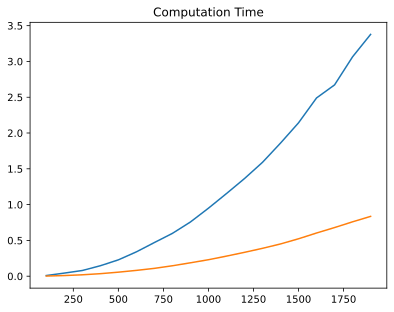

In [5]:
plt.plot(*zip(*[(size, timeit(dtw_distance, size)) for size in tqdm(range(100, 2000, 100))]))
plt.plot(*zip(*[(size, timeit(improved_dtw, size)) for size in tqdm(range(100, 2000, 100))]))
plt.title("Computation Time")

100%|██████████| 900/900 [06:26<00:00,  2.33it/s]


Text(0.5, 1.0, 'Computation Time')

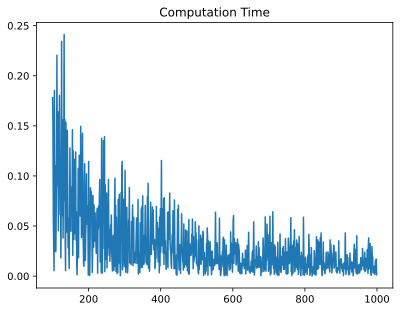

In [ ]:
def error(dtw1, dtw2, size=10):
	ts1 = generate_sine_time_series(size)
	ts2 = generate_sine_time_series(size)
	ds1 = dtw1(ts1, ts2)[0]
	ds2 = dtw2(ts1, ts2)[0]
	return abs(ds1 - ds2) / ds1

plt.plot(*zip(*[(size, error(dtw_distance, improved_dtw, size)) for size in tqdm(range(100, 1000, 1))]))
plt.title("Relative Error")